In [57]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from tqdm.notebook import tqdm

%matplotlib inline

# Сырые данные

## Считываем данные из .csv

Некоторые данные (такие как рубрики и признаки), представлены строками значений. Преобразуем их в списки чисел. 

In [58]:
to_list = lambda rubrics: [int(rubric) for rubric in str(rubrics).split(' ')]
def apply_to_columns(df, columns, func=to_list):
    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[~df[column].isnull(), column].apply(func)

В первую очередь нам понадобятся данные по __пользователям__, __организациям__ и сами __отзывы__. 

In [59]:
users = pd.read_csv('data/users.csv') # Информация о городе проживания пользователя:
print('Users: ', users['user_id'].nunique())
users.head(3)

Users:  1252801


,user_id,city
0,523295021912509756,msk
1,11952159487361099606,msk
2,16879036589969590999,msk


# NLP

Описание извлекаемых из отзывов аспектов. Множество аспектов извлекается из отзыва с помощью NLP-алгоритма и может быть неточным.


In [60]:
aspects = pd.read_csv('data/aspects.csv')
aspects.sample(10)

,aspect_id,aspect_name
103,320,Мясной Ресторан
124,357,Танцевальный Бар
34,249,Вино
11,12,Пицца
2,3,Интерьер
31,97,Столовая
133,372,Спагетти
102,319,Рыбный Ресторан
22,24,Караоке
106,323,Пироговая


Описание особенностей организаций. Как правило, множество особенностей организации заполняется ее владельцем 
и может быть неточным.

In [61]:
features = pd.read_csv('data/features.csv')
features.sample(10)

,feature_id,feature_name
32,21216,organic_food
52,3501754799,pickup
2,288,accepted_credit_cards
48,3501685156,table_games
31,20422,payment_by_credit_card
33,21247,sports_broadcasts
23,11634,free_delivery
54,3501769434,coffee_shop
28,11867,business_lunch
21,11617,takeaway


In [62]:
orgs = pd.read_csv('data/organisations.csv')

columns = ['rubrics_id', 'features_id'] # create lists
apply_to_columns(orgs, columns)

orgs.head(5)

,org_id,city,average_bill,rating,rubrics_id,features_id
0,16848414477362211020,spb,1000.0,4.479702,"[30776, 31375]","[1018, 1509, 11177, 11617, 11629, 11704, 11867..."
1,1430604733320164116,spb,1000.0,4.514509,"[30776, 30770]","[246, 1018, 11617, 11629, 11704, 11867, 20422,..."
2,9880309324224147401,spb,1000.0,3.884615,"[30770, 30774]","[1018, 11177, 11617, 11629, 11704, 11867, 2042..."
3,5617879987171966456,spb,1000.0,NaN,"[30774, 30775]","[1018, 1509, 10596, 11177, 11629, 11634, 11704..."
4,5241461680470612149,spb,1000.0,4.532468,[30776],"[1018, 11177, 11617, 11629, 11704, 11867, 2042..."


`organisations.csv` - Информация об организациях:

* `org_id:` идентификатор организации
* `city_id:` город организации
* `average_bill:` средний чек в рублях (округленный с точностью до 500 рублей)
* `avg_rating:` средний рейтинг (в том числе с учетом не перечисленных в файле reviews.csv отзывов и оценок)
* `rubric_id:` рубрика опрганизации
* `feature_ids:` набор известных особенностей данной организации.

In [63]:
def count_feature(x):
    try: return len(x)
    except: return 0

orgs['feature_count'] = orgs['features_id'].apply(count_feature)

orgs.sample(3)

,org_id,city,average_bill,rating,rubrics_id,features_id,feature_count
9549,10737582216015295829,msk,NaN,4.92,[31401],"[10447, 20422]",2
12363,5838832638823781722,msk,500.0,4.50,[31495],"[1018, 11177, 11617, 11704, 20422, 273469383]",6
60707,1836634166154754270,msk,NaN,5.00,[30770],"[20422, 2020795524]",2


In [64]:
# # orgs.feature_count.hist()
# orgs.average_bill.value_counts()

Чтобы не делать __join__ каждый раз, когда нам потребуется узнать, из какого города организация или пользователь, сразу добавим эту информацию в отзывы - `reviews.csv` - обучающее множество собрано за `X = 1217` дней, тестовое множество – за последующие `Y = 107` дней.

В этом файле дана информация об отзывах и оценках, оставленных некоторым множеством жителей Москвы и Санкт-Петерубрга в течение обучающего периода:

* `user_id`: идентификатор пользователя
* `org_id`: идентификатор организации
* `ts`: время отзыва (в днях от начала обучающего периода)
* `rating`: поставленная оценка
* `aspect_ids`: набор упомянутых в тексте отзыва аспектов.

In [65]:
reviews = pd.read_csv('data/reviews.csv', low_memory=False)

print('Reviews: ', len(reviews))
print('Users review: ', reviews.user_id.nunique())

# encode users ids as numeric
print('Приклеим информацию по юзерам')
reviews = reviews.merge(users, on='user_id', how='left')
reviews = reviews.rename({'city': 'user_city'}, axis=1)

print('Приклеим информацию по организациям')
orgs.rename({'rating': 'org_rating'}, axis=1, inplace=True)
reviews = reviews.merge(orgs[['org_id', 'city','org_rating']], on='org_id', how='left') # encode orgs ids as numeric
reviews = reviews.rename({'city': 'org_city'}, axis=1)


columns = ['aspects'] # create lists
apply_to_columns(reviews, columns)

print('Удалим дубли')
len_before_drop_duplics = len(reviews)
reviews.drop_duplicates(['user_id', 'org_id','rating','ts','user_city','org_city'], inplace=True) # Удаляем дубли
len_after_drop_duplics = len(reviews)
print('Выброшено дублей: ', len_before_drop_duplics - len_after_drop_duplics)

reviews.sample(10)

Reviews:  3640835
Users review:  1252801
Приклеим информацию по юзерам
Приклеим информацию по организациям
Удалим дубли
Выброшено дублей:  58038


,user_id,org_id,rating,ts,aspects,user_city,org_city,org_rating
2590543,6794806474361658617,17449310556511053368,4.0,436,NaN,spb,spb,4.462428
2037747,14830066253731475063,11642510571342462316,5.0,779,NaN,msk,msk,4.626263
3454986,15474960006067312773,7349575975764022325,5.0,970,NaN,msk,msk,4.444444
776148,3220537195765978359,5587443500834325077,5.0,370,"[7, 38]",msk,msk,4.458694
3191201,4864131267870421172,12505232768941548563,4.0,1115,NaN,msk,msk,4.413793
1425779,3689745262013259045,12070475576098814794,5.0,1215,NaN,msk,msk,4.176471
2540637,12063859672478847904,1002401688084545392,5.0,580,NaN,msk,msk,4.492007
2916917,14123633295053930265,16417590888904748029,5.0,345,NaN,msk,msk,3.766667
943445,1632253034035400958,1593380652788320661,5.0,918,NaN,spb,spb,4.351190
2855881,13259836703708758524,4750022828396262408,5.0,986,[6],msk,msk,4.270737


In [66]:
# activity.columns, reviews.columns

In [67]:
print("Добавим фичей")    
reviews['aspect_count'] = reviews['aspects'].apply(count_feature)
activity = reviews.groupby(by='user_id', as_index = False).agg(
    user_mean_rating = ('rating', 'mean'),
    user_review_activity = ('rating', 'count'),
    user_aspect_activity = ('aspect_count', 'sum'))

reviews = reviews.merge(activity[['user_id', 'user_mean_rating',
                                  'user_review_activity', 'user_aspect_activity']], on='user_id', how='left') # encode orgs ids as numeric
reviews.head(5)


Добавим фичей


,user_id,org_id,rating,ts,aspects,user_city,org_city,org_rating,aspect_count,user_mean_rating,user_review_activity,user_aspect_activity
0,16998268288908323644,7184895086928047809,2.0,105,NaN,msk,msk,4.038688,0,3.25,4,0
1,12235230637700316274,11420440322893824394,3.0,890,[17],msk,msk,3.750000,1,3.00,7,1
2,2706795762761414590,11993738663105455885,3.0,936,NaN,spb,spb,4.078873,0,4.00,6,1
3,2522006254806484630,18200844491365025705,3.0,1048,[6],spb,spb,4.460784,1,4.40,5,10
4,2035736119522953868,7143808482480365209,5.0,1185,NaN,spb,spb,4.226582,0,5.00,1,0


**Отлично, теперь с отзывами будет удобно работать.**  Посмотрим на распределение новых отзывов по дням, чтобы понять, как лучше организовать валидацию. 

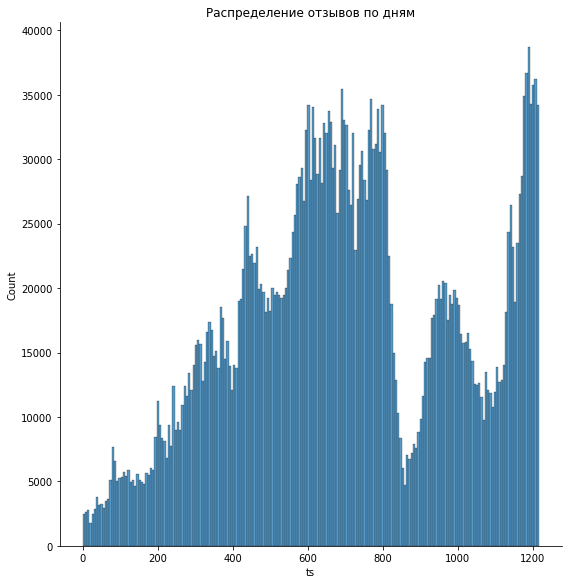

In [68]:
sns.displot(data=reviews, x='ts', height=8)
plt.title('Распределение отзывов по дням')
plt.show()

# Train-test split

In [69]:
from func import clear_df, extract_unique, count_unique, filter_reviews, train_test_split, process_reviews

In [70]:
print('Дней', reviews['ts'].max())

Дней 1216


**Всего в выборку попали отызывы за 1216 дней.**  Отложим в тестовую выборку отзывы за последние **100** дней.

In [71]:
train_reviews, test_reviews = train_test_split(reviews, 1116)
X_test, y_test = process_reviews(test_reviews)

Посмотрим, сколько всего уникальных пользователей попало в эту тестовую выборку:

In [72]:
len(X_test)

12044

# Метрика

Метрика принимает на вход два DataFrame, имеющих такую же структуру, как и **y_test**. `print_score` домножает реальное значение метрики на `100` так же, как и в контесте. Подобная имплементация используется для оценки **submission**.

In [73]:
from func import MNAP, print_score

In [74]:
N = 20
MNAP_N = MNAP(N)

# Подходы без машинного обучения

In [75]:
spb_orgs = orgs[orgs['city'] == 'spb']['org_id']
msk_orgs = orgs[orgs['city'] == 'msk']['org_id']
test_users_with_locations = X_test.merge(users, on='user_id')

## N самых популярных мест

Предыдущий подход, очевидно, не очень удачно предсказывает, какие места посетит пользователей. 

Попробуем улучшить стратегию: будем предлагать пользователям самые популярные места, то есть те, на которые оставлено больше всего отзывов. 

In [76]:
msk_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'msk')]['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'spb')]['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [77]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 4.24


Отлично, метрика немного улучшилась. Но стоит попробовать доработать эту тактику. 

## N самых популярных мест среди туристов

In [78]:
tourist_reviews = train_reviews[train_reviews['rating'] >= 4.0]

# набор отзывов только от туристов
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [79]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 6.44


Метрика улучшилась ещё!

## N самых популярных мест среди туристов с учетом оценки заведения

In [80]:
tourist_reviews = train_reviews[(train_reviews['rating'] >= 4.0) & (train_reviews['org_rating'] >=  4.0)]

# набор отзывов только от туристов
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [81]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 6.50


Метрика улучшилась ещё немного.

## N / rubrics_count самых популярных мест из каждой рубрики

In [82]:
from func import extract_top_by_rubrics

In [83]:
orgs.head(2)

,org_id,city,average_bill,org_rating,rubrics_id,features_id,feature_count
0,16848414477362211020,spb,1000.0,4.479702,"[30776, 31375]","[1018, 1509, 11177, 11617, 11629, 11704, 11867...",11
1,1430604733320164116,spb,1000.0,4.514509,"[30776, 30770]","[246, 1018, 11617, 11629, 11704, 11867, 20422,...",10


In [84]:
msk_orgs = extract_top_by_rubrics(orgs, tourist_reviews[tourist_reviews['org_city'] == 'msk'], N)
spb_orgs = extract_top_by_rubrics(orgs, tourist_reviews[tourist_reviews['org_city'] == 'spb'], N)

In [85]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 5.73


# Время ML! Коллаборативная фильтрация

## Memory-based

Для этой группы методов требуется явное построение матрицы __пользователь-организация__ (__interaction matrix__), где на пересечении `i`-ой строки и `j`-ого столбца будет рейтинг, который `i`-ый пользователь выставил `j`-ой организации или же пропуск, если рейтинг не был установлен. 

In [86]:
from func import reduce_reviews, create_mappings, map_ids, interaction_matrix

## ALS

In [87]:
import implicit  # !pip install implicit

In [101]:
def make_predictions(interactions, X_test, N, mod='ALS'):
    '''
    make_predictions(interactions, X_test, N)
        Делает рекомендации для пользователей из <X_test> на основе матрицы взаимодействий. 
        
        Parameters
        ----------
        interactions : scipy.sparse.csr_matrix
            Разреженная матрица взаимодействий.
            
        X_test : pd.DataFrame
            Набор тестовых пользователей, для которых нужно сделать рекомендации. 
        
        N : int
            Число рекомендаций для каждого пользователя. 
        
        Returns
        -------
        predictions : pd.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список рекомендованных для пользователя org_id.
        
    '''
    
    
    predictions = X_test[['user_id']].copy()
    predictions['target'] = pd.Series(dtype=object)
    predictions = predictions.set_index('user_id')
    
    
    interactions, (train_users_len, inner_orgs_len), mappings = interactions
    (index_to_uid, uid_to_index), (index_to_oid, oid_to_index) = mappings

    base_model = implicit.als.AlternatingLeastSquares(#use_gpu=True, 
        factors=30,  iterations=1000, 
        regularization=0.05,  random_state=42,
        num_threads = 4,
        #calculate_training_loss=True
    )
    base_model.fit(interactions.T)

    
    orgs_to_filter = list(np.arange(inner_orgs_len))

    recommendations = base_model.recommend_all(
        interactions,
        N=N,
        filter_already_liked_items=True,
        filter_items=orgs_to_filter,
        show_progress=True
    )
    
    for user_id in tqdm(X_test['user_id'].values, leave=False):
        predictions.loc[user_id, 'target'] = list(
            map(
                lambda org_index: index_to_oid[org_index], 
                recommendations[uid_to_index[user_id]]
            )
        )
        
    return predictions.reset_index()

In [102]:
#mean_rating = train_reviews['rating'].mean()
train_reviews['rating'].fillna(0, inplace=True)


train_reviews = train_reviews[train_reviews['rating'] >= 3]
 
# train_reviews.dropna(inplace=True)
train_reviews.rating.isnull().sum()

0

In [103]:
# train_reviews.isnull().sum()

In [104]:
msk_interactions = interaction_matrix(train_reviews,
                                      test_users_with_locations[test_users_with_locations['city'] == 'msk'],
                                      city = 'msk')

spb_interactions = interaction_matrix(train_reviews,
                                      test_users_with_locations[test_users_with_locations['city'] == 'spb'],
                                      city = 'spb')       
        
test_msk_users = test_users_with_locations[test_users_with_locations['city'] == 'msk']
test_spb_users = test_users_with_locations[test_users_with_locations['city'] == 'spb']

# Делаем предсказания
msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

print_score(MNAP_N(y_test, predictions))

Собираем матрицу взаимодействий: all_users: 29832 all_orgs: 15092
Собираем матрицу взаимодействий: all_users: 23327 all_orgs: 15092


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Submission

Выберем лучший метод на валидации, переобучим его на всей выборке и сделаем предсказание на тестовой выборке. 

**Формат вывода:**
Для каждого пользователя из файла `test_users.csv` необходимо приложить список из не более чем 20 организаций, относящихся к городу, отличному от города проживания пользователя.

## Without ML

In [ ]:
# набор отзывов только от туристов


tourist_reviews = reviews[(reviews['rating'] >= 4.0) & (reviews['org_rating'] >= 4.0)]
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()


msk_orgs = str(' '.join(map(str, msk_orgs)))
spb_orgs = str(' '.join(map(str, spb_orgs)))

In [116]:
test_users = pd.read_csv('data/test_users.csv')
test_users['city'] = test_users.merge(users, on='user_id')['city']
test_users.head(3)

,user_id,city
0,3545210947248911048,msk
1,15271987121288045390,msk
2,15016858616184265932,msk


In [ ]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users.apply(choose, axis=1)
 
predictions = test_users[['user_id']]
predictions['target'] = target

predictions.head()

In [ ]:
predictions.to_csv('answers.csv', index=None)

## With ML

In [ ]:
mean_rating = reviews['rating'].mean()
reviews['rating'].fillna(mean_rating, inplace=True)
reviews = reviews[reviews['rating'] > 3]
reviews.head()

In [ ]:
test_users = pd.read_csv('data/test_users.csv')
test_users = test_users.merge(users, on='user_id')

msk_interactions = interaction_matrix(
    reviews,                                  
    test_users[test_users['city'] == 'msk'][['user_id', 'city']],
    city = 'msk'
)

spb_interactions = interaction_matrix(
    reviews,
    test_users[test_users['city'] == 'spb'][['user_id', 'city']],
    city = 'spb'
)

msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

In [ ]:
predictions['target'] = predictions['target'].apply(lambda orgs: ' '.join(map(str, orgs)))
predictions.head(2)

In [ ]:
predictions.to_csv('answers_ml.csv', index=None)

# Surprise - SVD/KNN и другие (Андрей/Саша)

In [106]:
from surprise import Reader, Dataset

from surprise import SVD,SVDpp
from surprise import NMF,BaselineOnly, NormalPredictor, KNNWithZScore, SlopeOne, CoClustering
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [107]:
print(len(reviews))
surprise_reviews = reviews[(reviews.rating > 2) & (reviews.org_rating > 3.9)]
print(len(surprise_reviews))

3582797
2921849


In [108]:
ratings_dict = {'itemID': list(surprise_reviews.org_id),
                'userID': list(surprise_reviews.user_id),
                'rating': list(surprise_reviews.rating)}

surprise_reviews = pd.DataFrame(ratings_dict)
print('Filtered reviews', len(surprise_reviews))

# A reader is still needed but only the rating_scale param is required.
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(4.0, 5.0))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(surprise_reviews[['userID', 'itemID', 'rating']], reader)

Filtered reviews 2921849


In [109]:
# !smi-nvidia

In [110]:
surprise_reviews.head()

,itemID,userID,rating
0,11993738663105455885,2706795762761414590,3.0
1,18200844491365025705,2522006254806484630,3.0
2,7143808482480365209,2035736119522953868,5.0
3,5094937364114858089,11502321723490708343,5.0
4,8786304251059473262,780616808613468272,5.0


In [112]:
# svd
algo = SVD(verbose = True, reg_all = 0.05)
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True, n_jobs=120)
# #evaluate(algo, data, measures=['RMSE'])


In [113]:
trainset = data.build_full_trainset()
algo.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [120]:
algo.predict(uid=3545210947248911048, )

TypeError: predict() missing 1 required positional argument: 'iid'

In [128]:
# import difflib
# import random

# def get_book_id(book_title, metadata):
    
#     """
#     Gets the book ID for a book title based on the closest match in the metadata dataframe.
#     """
    
#     existing_titles = list(metadata['itemID'].values)
#     closest_titles = difflib.get_close_matches(book_title, existing_titles)
#     book_id = metadata[metadata['title'] == closest_titles[0]]['id'].values[0]
#     return book_id

# def get_book_info(book_id, metadata):
    
#     """
#     Returns some basic information about a book given the book id and the metadata dataframe.
#     """
    
#     book_info = metadata[metadata['id'] == book_id][['id', 'isbn', 
#                                                     'authors', 'title', 'original_title']]
#     return book_info.to_dict(orient='records')

# def predict_review(user_id, book_title, model, metadata):
    
#     """
#     Predicts the review (on a scale of 1-5) that a user would assign to a specific book. 
#     """
    
#     book_id = get_book_id(book_title, metadata)
#     review_prediction = model.predict(uid=user_id, iid=book_id)
#     return review_prediction.est

# def generate_recommendation(user_id, model, metadata, thresh=4):
    
#     """
#     Generates a book recommendation for a user based on a rating threshold. Only
#     books with a predicted rating at or above the threshold will be recommended
#     """
    
#     book_titles = list(metadata['title'].values)
#     random.shuffle(book_titles)
    
#     for book_title in book_titles:
#         rating = predict_review(user_id, book_title, model, metadata)
#         if rating >= thresh:
#             book_id = get_book_id(book_title, metadata)
#             return get_book_info(book_id, metadata)

In [147]:
surprise_reviews.sort_values(by='rating', inplace=True, ascending=False)
surprise_reviews

,itemID,userID,rating
496427,2916719444900146374,6068627806756752881,5.0
329649,12909766905446674254,13241629906923134089,5.0
1872752,9769434490200935948,6257039458331332559,5.0
329516,10961612776411136990,11183345847208725480,5.0
1872396,4851991569272774544,18296098592076528643,5.0
...,...,...,...
1233459,17014869523848664233,7223741147335986199,3.0
1233472,7899702990879432924,14181091909821710449,3.0
2106087,12402423256803525160,14471692731518354347,3.0
246566,4743791168256622584,7889570908919377547,3.0


In [152]:
final_preds_dict = {}
preds_item = {}

thresh = 4.5

users = test_users['user_id'].values
items  = surprise_reviews['itemID'].values

def rep_dict(d, val, MIN):
    for k in d.keys():
        if d[k]==MIN:
            d[k]=val
            return d


for user in tqdm(users):
    for item in items[:50]: # TODO убрать костыль
        
        pred = algo.predict(uid=user, iid=item)
        rating = pred.est
        
        if len(preds_item)==0 or len(preds_item) <= 20: # warm start
            preds_item[item] = rating
        
        elif rating > thresh:
            MIN = min(preds_item.values())
            if rating > MIN:
                preds_item = rep_dict(preds_item, rating, MIN)
                
            preds_item[item] = rating
            
#             print(pred)
        
    final_preds_dict[user] = preds_item.keys()

        
        #print()
    

  0%|          | 0/16967 [00:00<?, ?it/s]

In [154]:
# #final_preds_dict

# for k, v in final_preds_dict.items():
    
    
# test_users

,user_id,city
0,3545210947248911048,msk
1,15271987121288045390,msk
2,15016858616184265932,msk
3,12457244142928722989,msk
4,13339684649926251468,spb
...,...,...
16962,1191875913294598364,msk
16963,3866507700167344338,msk
16964,11434952144484188987,msk
16965,7010426792722803474,spb


# Использование NLP данных (Андрей)

In [ ]:
# рекомендации org для test_users на основе тестовых данных

# LightFM (Саша)

In [ ]:
# def make_predictions_LightFM(interactions, X_test, N, mod='ALS'):
#     '''
#     make_predictions(interactions, X_test, N)
#         Делает рекомендации для пользователей из <X_test> на основе матрицы взаимодействий. 
        
#         Parameters
#         ----------
#         interactions : scipy.sparse.csr_matrix
#             Разреженная матрица взаимодействий.
            
#         X_test : pd.DataFrame
#             Набор тестовых пользователей, для которых нужно сделать рекомендации. 
        
#         N : int
#             Число рекомендаций для каждого пользователя. 
        
#         Returns
#         -------
#         predictions : pd.DataFrame
#             DataFrame с колонками <user_id> и <target>. 
#             В <target> содержится список рекомендованных для пользователя org_id.
        
#     '''
    
    
#     predictions = X_test[['user_id']].copy()
#     predictions['target'] = pd.Series(dtype=object)
#     predictions = predictions.set_index('user_id')
    
    
#     interactions, (train_users_len, inner_orgs_len), mappings = interactions
    
  
    
#     (index_to_uid, uid_to_index), (index_to_oid, oid_to_index) = mappings

    
#     base_model = LightFM(loss='warp')
#     base_model.fit(train,
#               user_features=user_features,
#               item_features=item_features,
#               epochs=20)
#     predictions = base_model.predict(test_user_ids,
#                                 test_item_ids,
#                                 # user_features=user_features,
#                                 item_features=item_features)


    
# #     base_model = implicit.als.AlternatingLeastSquares(
# #         factors=100,  iterations=150, 
# #         regularization=0.05,  random_state=42,
# #         #num_threads = 4,
# #         #calculate_training_loss=True
# #     )
# #     base_model.fit(interactions.T)

    
    
    
    
#     orgs_to_filter = list(np.arange(inner_orgs_len))

#     recommendations = base_model.recommend_all(
#         interactions,
#         N=N,
#         filter_already_liked_items=True,
#         filter_items=orgs_to_filter,
#         show_progress=True
#     )
    
#     for user_id in tqdm(X_test['user_id'].values, leave=False):
#         predictions.loc[user_id, 'target'] = list(
#             map(
#                 lambda org_index: index_to_oid[org_index], 
#                 recommendations[uid_to_index[user_id]]
#             )
#         )
        
#     return predictions.reset_index()

In [ ]:
msk_interactions = interaction_matrix(train_reviews,
                                      test_users_with_locations[test_users_with_locations['city'] == 'msk'],
                                      city = 'msk')
 
# Делаем предсказания
msk_predictions = make_predictions(msk_interactions, 
                                   test_users_with_locations[test_users_with_locations['city'] == 'msk'], N)
 

predictions = pd.concat([msk_predictions, spb_predictions])

print_score(MNAP_N(y_test, predictions))

In [51]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

# Instantiate and train the model


predictions = X_test[['user_id']].copy()
predictions['target'] = pd.Series(dtype=object)
predictions = predictions.set_index('user_id')


msk_interactions = interaction_matrix(train_reviews,
                                      test_users_with_locations[test_users_with_locations['city'] == 'msk'],
                                      city = 'msk')

interactions, (train_users_len, inner_orgs_len), mappings = msk_interactions
(index_to_uid, uid_to_index), (index_to_oid, oid_to_index) = mappings

ModuleNotFoundError: No module named 'lightfm'

In [ ]:
model = LightFM(loss='warp')

model.fit(interactions,
#           user_features=user_features,
#           item_features=item_features,
          epochs=20)
print('Обучился')
test_item_ids = np.arange(inner_orgs_len)
test_user_ids = np.arange(train_users_len)

predictions = model.predict(test_user_ids,
                            test_item_ids,
#                             user_features=user_features,
#                             item_features=item_features
                           )


# # Evaluate the trained model
# test_precision = precision_at_k(model, data['test'], k=5).mean()
# test_precision